# **FRAUD DETECTION MODEL**

Task 1: Collect and preprocess transaction data, ensuring to include both fraudulent and non-fraudulent examples.

## Import the libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
!pip install statsmodels

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
import joblib

## Read Data

In [4]:
df = pd.read_csv('/content/Fraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


## Preprocessing

In [5]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,69858.000000,6.985800e+04,6.985800e+04,6.985800e+04,6.985800e+04,6.985700e+04,69857.000000,69857.0
mean,7.893326,1.640176e+05,9.043066e+05,9.202980e+05,8.543522e+05,1.185141e+06,0.001532,0.0
std,1.874512,3.313730e+05,2.791616e+06,2.829881e+06,2.403000e+06,2.871791e+06,0.039107,0.0
min,1.000000,6.300000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
25%,8.000000,9.011012e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
50%,8.000000,4.404918e+04,1.990850e+04,0.000000e+00,1.416050e+04,2.113068e+04,0.000000,0.0
75%,9.000000,1.991307e+05,1.721175e+05,1.940205e+05,5.186073e+05,9.824113e+05,0.000000,0.0
max,9.000000,1.000000e+07,3.379739e+07,3.400874e+07,3.130692e+07,3.197699e+07,1.000000,0.0


In [6]:
print("Shape:",df.shape)

Shape: (69858, 11)


In [7]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           float64
isFlaggedFraud    float64
dtype: object

In [8]:
print("Total Null Values:",df.isnull().sum())

Total Null Values: step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    1
isFraud           1
isFlaggedFraud    1
dtype: int64


In [9]:
print("Total Duplicate Values:\n",df.duplicated().sum())

Total Duplicate Values:
 0


In [10]:
print("Total Fraud transactions: ", len(df[df['isFraud'] == 1]))
print("Total Legit transactions: ", len(df[df['isFraud'] == 0]))

Total Fraud transactions:  107
Total Legit transactions:  69750


([<matplotlib.patches.Wedge at 0x7b2b330a6f80>,
 [Text(-1.0999872643693773, 0.005293224459041608, ''),
  Text(1.0999872640422101, -0.0052932924473726335, '')],
 [Text(-0.5999930532923876, 0.002887213341295422, '99.85%'),
  Text(0.5999930531139327, -0.002887250425839618, '0.15%')])

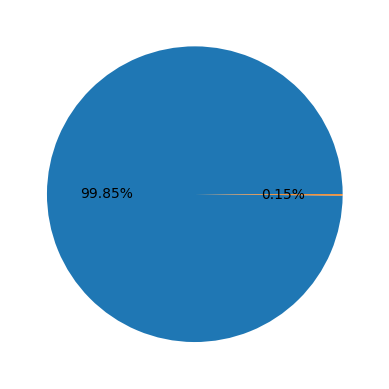

In [11]:
plt.pie(df['isFraud'].value_counts(),  autopct='%.2f%%')

**The ratio of Fraud to Legit transactions is highly unbalanced**

In [12]:
df.nunique()

step                  9
type                  5
amount            69533
nameOrig          69858
oldbalanceOrg     41993
newbalanceOrig    34045
nameDest          38011
oldbalanceDest    36977
newbalanceDest    13553
isFraud               2
isFlaggedFraud        1
dtype: int64

**Correlation**

<Axes: >

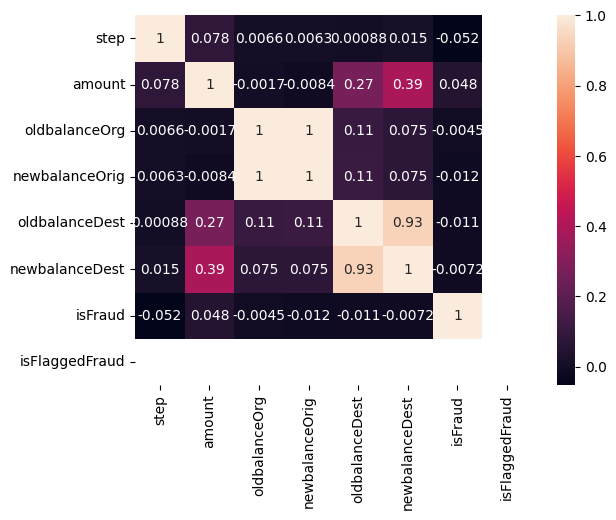

In [13]:
sb.heatmap(data=df.corr(numeric_only=True), annot=True)

<Axes: xlabel='count', ylabel='type'>

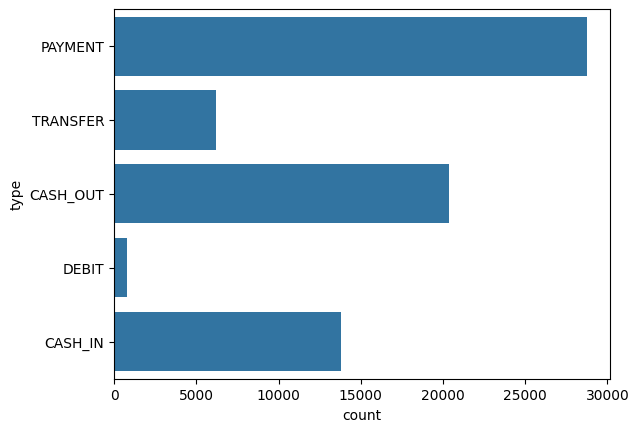

In [14]:
sb.countplot(df['type'])

## Feature Engineering

In [15]:
dfc = df.copy()
dfc.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


In [16]:
dfc.describe(include='object') # categorical features

,type,nameOrig,nameDest
count,69858,69858,69858
unique,5,69858,38011
top,PAYMENT,C731155005,C985934102
freq,28733,1,76


There are 3 attributes with type **object** which will be label encoded.

In [17]:
dfc.fillna(dfc.mode().iloc[0], inplace=True)
encoder = {}
for i in dfc.select_dtypes('object').columns:
    encoder[i] = LabelEncoder()
    dfc[i] = encoder[i].fit_transform(dfc[i])
dfc.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,8190,170136.0,160296.36,23754,0.0,0.0,0.0,0.0
1,1,3,1864.28,23978,21249.0,19384.72,24694,0.0,0.0,0.0,0.0
2,1,4,181.00,10826,181.0,0.00,7155,0.0,0.0,1.0,0.0
3,1,1,181.00,64093,181.0,0.00,6352,21182.0,0.0,1.0,0.0
4,1,3,11668.14,37707,41554.0,29885.86,12607,0.0,0.0,0.0,0.0


**Checking for Multicollinearity**

In [18]:
# variation inflation factor
vif = pd.DataFrame()
vif['variables'] = dfc.columns
vif['VIF'] = [variance_inflation_factor(dfc.values,i) for i in range(dfc.shape[1])]
print(vif)

         variables         VIF
0             step    5.478576
1             type    6.013851
2           amount    1.928353
3         nameOrig    3.569551
4    oldbalanceOrg  615.245188
5   newbalanceOrig  622.080670
6         nameDest    4.514834
7   oldbalanceDest    9.339876
8   newbalanceDest   10.541314
9          isFraud    1.033502
10  isFlaggedFraud         NaN


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1785: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


OldbalanceOrg and newbalanceOrig have high VIF values, indicating strong multicollinearity. Similarly, oldbalanceDest & newbalanceDest are also highly correlated. nameDest & nameOrig are also related and can be combined as well with all the other pairs and individual columns can be removed.

In [19]:
# Creating new columns for combined attributes
dfc['Amount_orig'] = dfc.apply(lambda x: x['oldbalanceOrg'] - x['newbalanceOrig'],axis=1)
dfc['Amount_dest'] = dfc.apply(lambda x: x['oldbalanceDest'] - x['newbalanceDest'],axis=1)
dfc['TransactionPath'] = dfc.apply(lambda x: x['nameOrig'] + x['nameDest'],axis=1)

dfc = dfc.drop(['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','step','nameOrig','nameDest'],axis=1)

In [20]:
dfc.head()

,type,amount,isFraud,isFlaggedFraud,Amount_orig,Amount_dest,TransactionPath
0,3,9839.64,0.0,0.0,9839.64,0.0,31944.0
1,3,1864.28,0.0,0.0,1864.28,0.0,48672.0
2,4,181.00,1.0,0.0,181.00,0.0,17981.0
3,1,181.00,1.0,0.0,181.00,21182.0,70445.0
4,3,11668.14,0.0,0.0,11668.14,0.0,50314.0


In [21]:
# Recalculating variation inflation factor
vif = pd.DataFrame()
vif['variables'] = dfc.columns
vif['VIF'] = [variance_inflation_factor(dfc.values,i) for i in range(dfc.shape[1])]
print(vif)

         variables       VIF
0             type  3.300455
1           amount  1.514988
2          isFraud  1.031672
3   isFlaggedFraud       NaN
4      Amount_orig  1.157265
5      Amount_dest  1.351272
6  TransactionPath  3.106350


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1785: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


<Axes: >

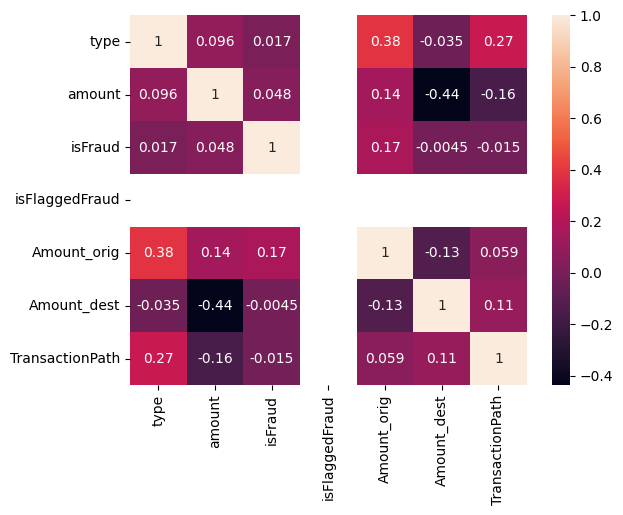

In [22]:
sb.heatmap(data=dfc.corr(numeric_only=True), annot=True)

## Model Training

In [23]:
x = dfc.drop(columns=['isFraud'])
y = dfc['isFraud']

In [24]:
x.value_counts()

type  amount       isFlaggedFraud  Amount_orig   Amount_dest  TransactionPath
4     10000000.00  0.0              10000000.00   0.00        68496.0            1
0     57.98        0.0             -57.98         18687.05    66431.0            1
4     3498660.78   0.0              114630.25    -5139497.96  42497.0            1
      3504119.07   0.0              41300.00     -5867471.31  21583.0            1
      3520997.05   0.0              245038.58    -3753218.86  37837.0            1
                                                                                ..
0     257.16       0.0             -257.16        53347.95    13227.0            1
      270.78       0.0             -270.78        3019.00     64648.0            1
      272.59       0.0             -272.59       -1011582.45  8499.0             1
      279.54       0.0             -279.54       -857591.34   66421.0            1
      340.45       0.0             -340.45        223382.27   60979.0            1
Name: cou

In [25]:
y.value_counts()

isFraud
0.0    69751
1.0      107
Name: count, dtype: int64

In [29]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.30,random_state=10)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [30]:
x_train.shape

(48900, 6)

In [31]:
x_test.shape

(20958, 6)

### Logistic Regression

In [56]:
isolation_forest = IsolationForest(contamination=0.01)
isolation_forest.fit(x_train)
y_pred_anomaly = isolation_forest.predict(x_train)

# Remove anomalies
x_train_filtered = x_train[y_pred_anomaly == 1]
y_train_filtered = y_train[y_pred_anomaly == 1]

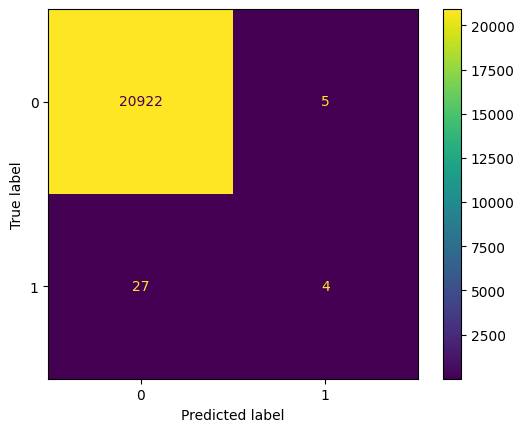

In [33]:
lr_model = LogisticRegression()
lr_model.fit(x_train_filtered, y_train_filtered)
y_pred1 = lr_model.predict(x_test)
joblib.dump(lr_model, 'lr_model.joblib')
confusion_matrix(y_test,y_pred1)
cm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,y_pred1))
cm.plot()

In [34]:
accuracy_score(y_test, y_pred1)*100

99.84731367496899

In [35]:
report1 = classification_report(y_test,y_pred1)
print(report1)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     20927
         1.0       0.44      0.13      0.20        31

    accuracy                           1.00     20958
   macro avg       0.72      0.56      0.60     20958
weighted avg       1.00      1.00      1.00     20958



The accuracy is misleading. For Label '0', the precision is 1 which implies that everytime '0' was predicted, it was correct but for Label '1' precision is only 0.44 which means the model is generating a lot of false positives. We can conclude that the model is heavily biased towards Label '0' which is a transaction being flagged not fraud and therefore not useful for our purpose.

### SVM

In [ ]:
svm_model = SVC(kernel='linear')
svm_model.fit(x_train, y_train)
y_pred2 = svm_model.predict(x_test)
joblib.dump(svm_model, 'SVM_model.joblib')

In [ ]:
confusion_matrix(y_test,y_pred2)
cm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,y_pred2))
cm.plot()

In [ ]:
accuracy_score(y_test, y_pred2)*100

In [ ]:
report2 = classification_report(y_test,y_pred2)
print(report2)

### Random Forest

In [36]:
rf_model = RandomForestClassifier(n_estimators=5, random_state=42)
rf_model.fit(x_train_filtered, y_train_filtered)
y_pred3 = rf_model.predict(x_test)
joblib.dump(rf_model, 'random_forest_model.joblib')

['random_forest_model.joblib']

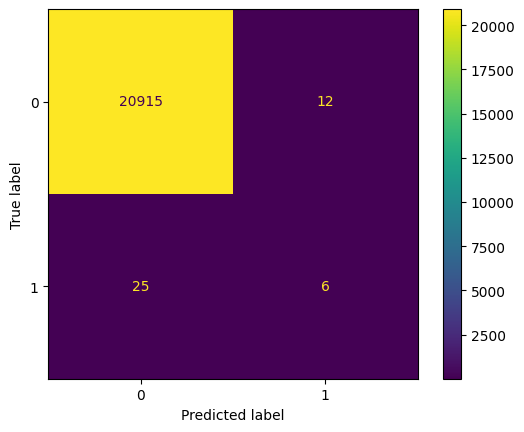

In [37]:
confusion_matrix(y_test,y_pred3)
cm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,y_pred3))
cm.plot()

In [38]:
accuracy_score(y_test, y_pred3)*100

99.82345643668289

In [39]:
report2 = classification_report(y_test,y_pred3)
print(report2)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     20927
         1.0       0.33      0.19      0.24        31

    accuracy                           1.00     20958
   macro avg       0.67      0.60      0.62     20958
weighted avg       1.00      1.00      1.00     20958



For the random forest model, Label '0' precision is also 1 which implies that everytime '0' was predicted, it was correct but for Label '1' precision is only 0.33 which means the model is generating more false positives than our first model , however, recall has increased to 0.19. This suggests the model is now identifying more true instances of class 1 than before, but is still missing a large portion. We can conclude that the model is heavily biased towards Label '0' which are transactions flagged Not Fraud and therefore not useful for our purpose and needs to be further optimised

In [46]:
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'log2', 0.5],
    'criterion': ['gini', 'entropy']
}

rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=50, cv=5, scoring='f1', random_state=42)

random_search.fit(x_train_filtered, y_train_filtered)
print(random_search.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': None, 'criterion': 'gini'}


In [62]:
rf_model2 = RandomForestClassifier(n_estimators=100, min_samples_split=2,
                                  min_samples_leaf=1, max_features=0.5,
                                  max_depth=None, criterion='gini', random_state=42)
rf_model2.fit(x_train_filtered, y_train_filtered)
y_pred4 = rf_model2.predict(x_test)
joblib.dump(rf_model2, 'random_forest_model_optimised.joblib')

['random_forest_model_optimised.joblib']

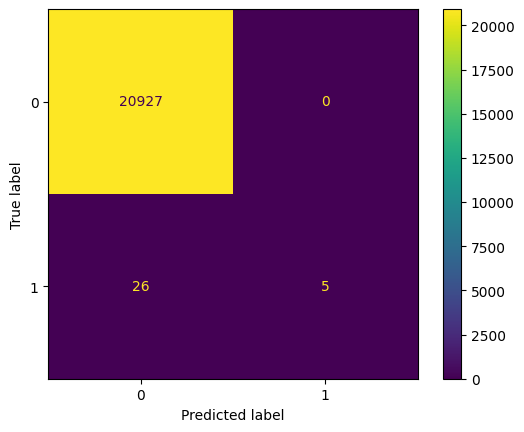

In [66]:
confusion_matrix(y_test,y_pred4)
cm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,y_pred4))
cm.plot()

In [67]:
accuracy_score(y_test, y_pred4)*100

99.87594236091229

In [68]:
report3 = classification_report(y_test,y_pred4)
print(report3)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     20927
         1.0       1.00      0.16      0.28        31

    accuracy                           1.00     20958
   macro avg       1.00      0.58      0.64     20958
weighted avg       1.00      1.00      1.00     20958



The accuracy has slightly increased and the precision score indicate that there were no false positives or negatives for all the non-fraudulent transactions. For the fraudulent transactions, only 16% were identified correctly, indicating a high number of false negatives i.e transactions that were fraudulent were flagged as non-fradulent by the model